In [64]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
%matplotlib inline

sns.set()

from sklearn.covariance import oas
import scipy.optimize as sci_opt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV

# Accuracy and Data

- Define weighted_accuracy function
- Import data and reshape
- Exploratory data analysis

### Weighted Accuracy function

In [3]:
def weighted_accuracy(y_test, y_pred):
    y_abs = np.abs(y_test)
    norm = y_abs.sum()
    score = ((np.sign(y_pred) == np.sign(y_test)) * y_abs).sum() / norm
    return score

### Loading Data

In [4]:
X_train = pd.read_csv('X_train_itDkypA.csv')
Y_train = pd.read_csv('y_train_3LeeT2g.csv', index_col=0)
X_test = pd.read_csv('X_test_Beg4ey3.csv')
X_train.head()

,ID,ID_DAY,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,...,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297,ID_TARGET
0,0,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.007596,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,139
1,1,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.007596,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,129
2,2,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.007596,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,136
3,3,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.007596,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,161
4,4,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.007596,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,217


In [5]:
Extra_data = pd.read_csv('supplementary_data_Vkoyn8z.csv')
Extra_data.head()

,ID_asset,CLASS_LEVEL_1,CLASS_LEVEL_2,CLASS_LEVEL_3,CLASS_LEVEL_4
0,216,2,2,12,20
1,238,2,2,12,21
2,45,3,5,20,32
3,295,10,22,49,77
4,230,4,10,28,47


- Reshaping Data: We transform the data so that each line corresponds to a specific day

In [6]:
idx_ret_features = np.where(X_train.columns.str.contains('RET'))[0]
init_ret_features = X_train.columns[idx_ret_features]
target_ret_features = np.array(['RET_' + str(s) for s in X_train['ID_TARGET'].unique()]) 

returns = {}

for day in tqdm(X_train.ID_DAY.unique()):
    u = X_train.loc[X_train.ID_DAY == day] # dataframe with all 'day' entries
    a = u.iloc[0, idx_ret_features] # select only idx_ret_features columns
    b = Y_train[X_train.ID_DAY == day]['RET_TARGET'] # select corresponding Y_train features
    b.index = np.array(['RET_' + str(s) for s in u.ID_TARGET.to_numpy()]) # 'RET_' + u.ID_TARGET
    returns[day] = pd.concat([a, b])
    
returns = pd.DataFrame(returns).T.astype(float)
returns.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2748/2748 [00:13<00:00, 209.11it/s]


,RET_0,RET_1,RET_102,RET_105,RET_106,RET_108,RET_109,RET_110,RET_114,RET_115,...,RET_88,RET_9,RET_90,RET_91,RET_93,RET_95,RET_96,RET_97,RET_98,RET_99
3316,-0.016501,0.018693,0.005316,NaN,0.001352,0.027374,-0.010890,0.057911,0.014155,0.021104,...,0.027113,0.008602,0.018250,0.038581,0.027588,0.001251,0.037917,-0.002689,0.002140,0.023026
3355,0.000674,0.005759,0.007938,NaN,-0.005017,-0.007413,-0.005980,0.011900,-0.011755,0.032401,...,0.017933,0.001658,0.061274,-0.018643,0.000372,-0.010232,-0.013496,0.013819,-0.036501,0.017736
1662,-0.000919,0.010430,0.007901,NaN,0.006959,0.005593,-0.066666,0.049822,0.021599,0.019816,...,0.016645,-0.016289,0.027690,-0.026479,0.006664,0.023721,0.013057,-0.008237,0.014655,0.011614
3405,-0.004989,0.004558,0.004325,NaN,-0.007720,0.002788,-0.038432,-0.021308,0.000595,0.001613,...,-0.039065,0.021897,-0.031456,0.029652,0.016171,-0.024835,-0.020391,0.006790,0.015796,-0.015763
1602,0.002468,-0.024584,0.008947,NaN,-0.004735,-0.031061,0.012366,0.045117,-0.015403,-0.015327,...,-0.028080,0.016530,0.019826,0.014627,0.010884,-0.025205,0.006157,-0.006526,0.002125,0.036186


### Exploring Data

<Axes: ylabel='Count'>

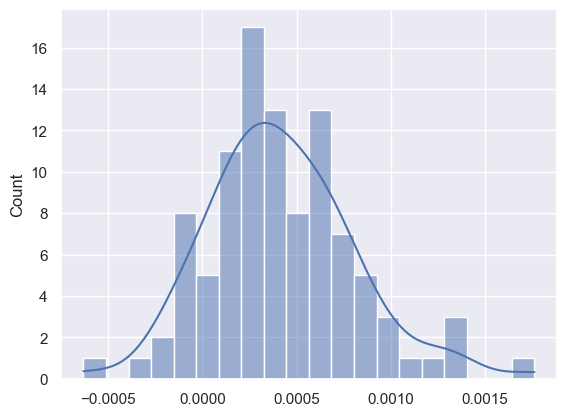

In [46]:
sns.histplot(data = returns[init_ret_features].mean(), kde=True, bins = 20)

<Axes: ylabel='Count'>

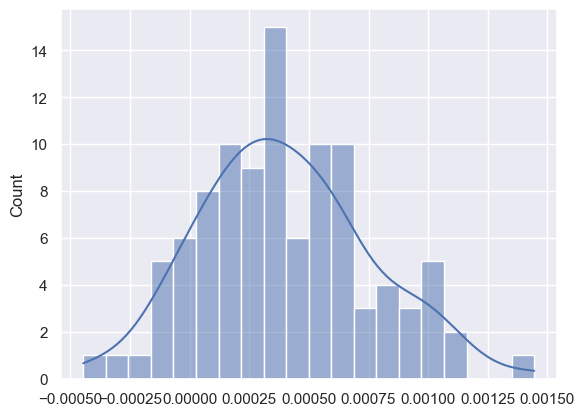

In [47]:
sns.histplot(data = returns[target_ret_features].mean(), kde=True, bins = 20)

- The two histograms looks rather similar. So it makes sense that the illiquid assets could be used to predict the prices for the liquid assets.

In [52]:
returns[target_ret_features].mean().sort_values(ascending=False)

RET_196    0.001445
RET_75     0.001150
RET_217    0.001141
RET_1      0.001039
RET_166    0.001033
             ...   
RET_52    -0.000120
RET_68    -0.000142
RET_98    -0.000239
RET_178   -0.000339
RET_90    -0.000446
Length: 100, dtype: float64

- Let us also check for possible outliers. These could happen, for instance, around the earnings report.

In [57]:
returns[returns>0.06] # RET_90 for instance

,RET_0,RET_1,RET_102,RET_105,RET_106,RET_108,RET_109,RET_110,RET_114,RET_115,...,RET_88,RET_9,RET_90,RET_91,RET_93,RET_95,RET_96,RET_97,RET_98,RET_99
3316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.061274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
returns['RET_90'].sort_values(ascending=False)

3572    0.114813
2544    0.107803
2143    0.105829
2110    0.104033
2282    0.102837
          ...   
2046         NaN
3690         NaN
3865         NaN
1403         NaN
2527         NaN
Name: RET_90, Length: 2748, dtype: float64

<Axes: xlabel='RET_90', ylabel='Count'>

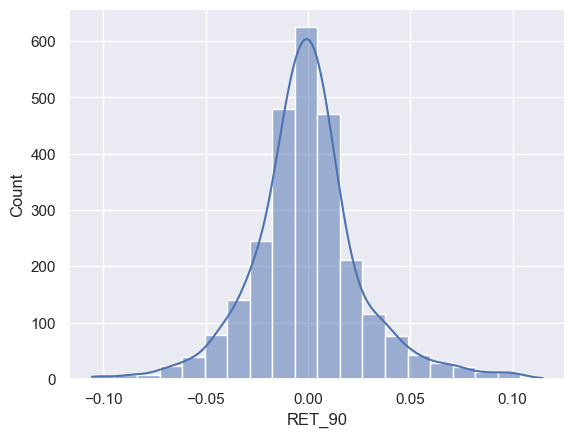

In [60]:
sns.histplot(data = returns['RET_90'], kde=True, bins = 20)

In [62]:
target_ret_features

array(['RET_139', 'RET_129', 'RET_136', 'RET_161', 'RET_217', 'RET_91',
       'RET_137', 'RET_8', 'RET_3', 'RET_9', 'RET_131', 'RET_21',
       'RET_54', 'RET_130', 'RET_269', 'RET_157', 'RET_249', 'RET_22',
       'RET_202', 'RET_132', 'RET_96', 'RET_7', 'RET_178', 'RET_68',
       'RET_44', 'RET_196', 'RET_292', 'RET_239', 'RET_279', 'RET_38',
       'RET_209', 'RET_207', 'RET_98', 'RET_65', 'RET_51', 'RET_78',
       'RET_177', 'RET_231', 'RET_119', 'RET_158', 'RET_80', 'RET_25',
       'RET_175', 'RET_151', 'RET_257', 'RET_75', 'RET_244', 'RET_149',
       'RET_85', 'RET_190', 'RET_13', 'RET_228', 'RET_144', 'RET_290',
       'RET_114', 'RET_166', 'RET_234', 'RET_34', 'RET_154', 'RET_225',
       'RET_185', 'RET_39', 'RET_272', 'RET_282', 'RET_90', 'RET_52',
       'RET_258', 'RET_291', 'RET_152', 'RET_133', 'RET_29', 'RET_274',
       'RET_106', 'RET_173', 'RET_33', 'RET_69', 'RET_17', 'RET_189',
       'RET_284', 'RET_218', 'RET_183', 'RET_206', 'RET_93', 'RET_16',
       'RET_2

<Axes: xlabel='RET_139', ylabel='Count'>

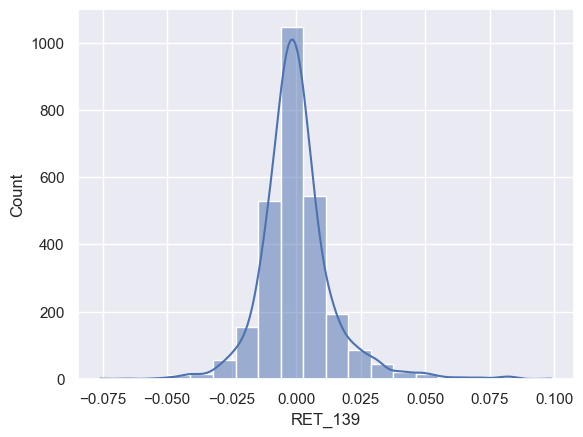

In [63]:
sns.histplot(data = returns['RET_139'], kde=True, bins = 20)

- From a look at some random examples, it seems that the illiquid assets have some possibly larger returns. We could consider neglecting those at some point. 

- Let us look at the additional data:

<Axes: xlabel='CLASS_LEVEL_4', ylabel='count'>

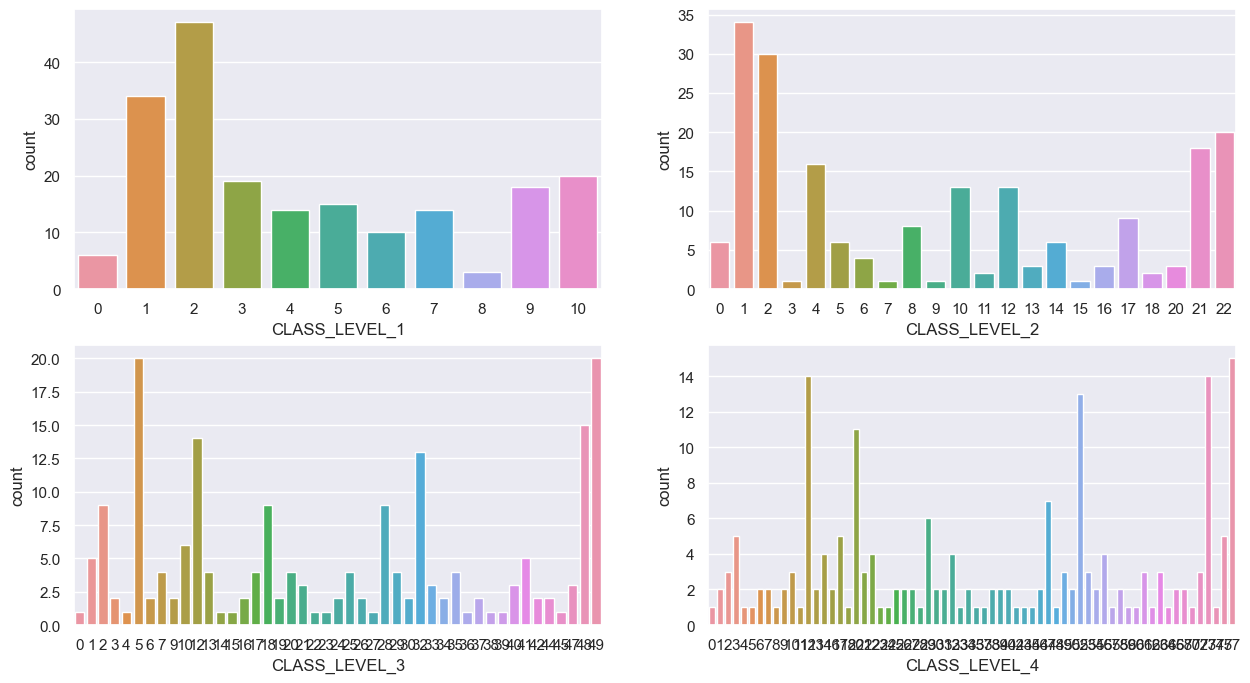

In [14]:
# Extra_data['CLASS_LEVEL_1'].value_counts()
fig, ax = plt.subplots(2, 2, figsize = (15,8))

sns.countplot(ax = ax[0][0], x = Extra_data['CLASS_LEVEL_1'])
sns.countplot(ax = ax[0][1], x = Extra_data['CLASS_LEVEL_2'])
sns.countplot(ax = ax[1][0], x = Extra_data['CLASS_LEVEL_3'])
sns.countplot(ax = ax[1][1], x = Extra_data['CLASS_LEVEL_4'])

- What is the relation between the classes? Given that class 1 has a particular value, what value will the other classes take? Let's check some examples.

<Axes: xlabel='CLASS_LEVEL_4', ylabel='count'>

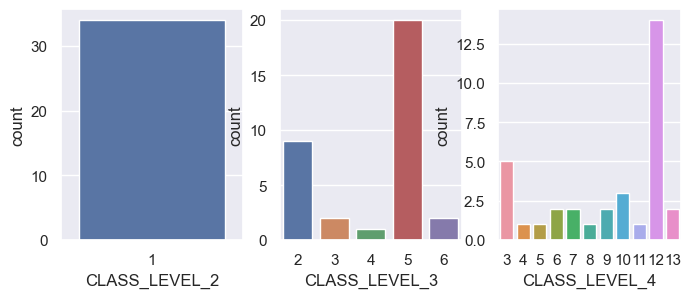

In [27]:
fig, ax = plt.subplots(1,3, figsize = (8,3))
sns.countplot(ax = ax[0], x = Extra_data[Extra_data['CLASS_LEVEL_1'] == 1]['CLASS_LEVEL_2'])
sns.countplot(ax = ax[1], x = Extra_data[Extra_data['CLASS_LEVEL_1'] == 1]['CLASS_LEVEL_3'])
sns.countplot(ax = ax[2], x = Extra_data[Extra_data['CLASS_LEVEL_1'] == 1]['CLASS_LEVEL_4'])

<Axes: xlabel='CLASS_LEVEL_4', ylabel='count'>

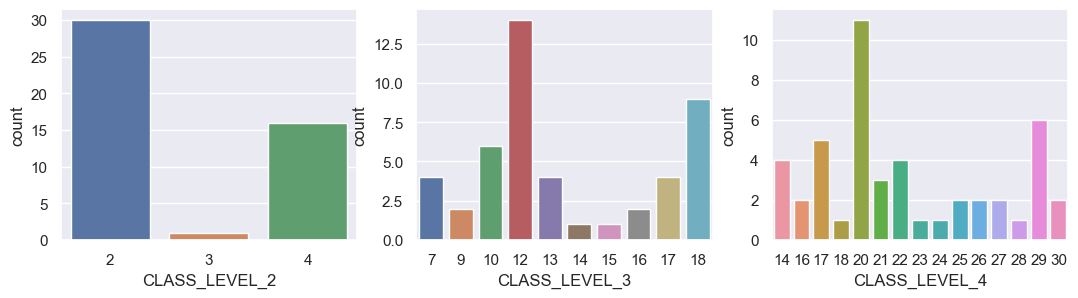

In [30]:
fig, ax = plt.subplots(1,3, figsize = (13,3))
sns.countplot(ax = ax[0], x = Extra_data[Extra_data['CLASS_LEVEL_1'] == 2]['CLASS_LEVEL_2'])
sns.countplot(ax = ax[1], x = Extra_data[Extra_data['CLASS_LEVEL_1'] == 2]['CLASS_LEVEL_3'])
sns.countplot(ax = ax[2], x = Extra_data[Extra_data['CLASS_LEVEL_1'] == 2]['CLASS_LEVEL_4'])

- Idea for feature engineering: can group assets by their classes, and take something like the mean to engineer new features.

# Benchmark Model

### Beta computation

We compute the $\beta$ between all assets. This matrix will determine the linear link between all assets.

This step is not necessary and could be done in the next step, but it is a good way to introduce the use of a matrix shrinkage, greatly used in finance when dealing with noisy data. See [here](https://scikit-learn.org/stable/auto_examples/covariance/plot_covariance_estimation.html) for more information.

In [333]:
from sklearn.covariance import oas

features = returns.columns
cov = pd.DataFrame(oas(returns.fillna(0))[0], index=features, columns=features)
beta = cov / np.diag(cov)
beta.head()

,RET_0,RET_1,RET_102,RET_105,RET_106,RET_108,RET_109,RET_110,RET_114,RET_115,...,RET_88,RET_9,RET_90,RET_91,RET_93,RET_95,RET_96,RET_97,RET_98,RET_99
RET_0,1.000000,0.126513,0.108238,0.128353,0.117609,0.070110,0.194425,0.080396,0.174791,0.118757,...,0.146664,-0.012388,0.155055,0.081016,0.181609,0.172702,0.063350,0.138673,0.104377,0.165404
RET_1,0.184228,1.000000,0.122461,0.214639,0.131930,0.117362,0.196036,0.174030,0.256237,0.223324,...,0.242727,-0.067669,0.228235,0.132136,0.177939,0.253013,0.105388,0.160021,0.109545,0.206384
RET_102,0.086988,0.067585,1.000000,0.149505,0.381845,0.146912,0.064788,0.142368,0.090649,0.104195,...,0.101701,0.008833,0.111743,0.043866,0.090732,0.162930,0.033348,0.124352,0.450246,0.230993
RET_105,0.141652,0.162670,0.205304,1.000000,0.195409,0.126792,0.134372,0.238152,0.197308,0.179270,...,0.165933,-0.003716,0.200567,0.221046,0.223728,0.219295,0.154519,0.205005,0.245215,0.320027
RET_106,0.093577,0.072087,0.378043,0.140882,1.000000,0.099451,0.076619,0.123011,0.100518,0.105586,...,0.096279,-0.018555,0.104224,0.020172,0.121545,0.133660,0.011020,0.144167,0.393937,0.196698


### Determine the pairs and beta coefficients

For each target asset (liquid assets), we determine the illiquid asset that has maximum correlation and we save the id and the associated beta coefficient.

In [6]:
target_ret_features = np.array(['RET_' + str(s) for s in X_train['ID_TARGET'].unique()]) 

In [334]:
proj_matrix = beta.T.loc[init_ret_features, target_ret_features] # look at beta between X and Y features only 
corr = returns.corr().loc[init_ret_features, target_ret_features] # Compute Correlation between X and Y features 

coeffs = {}
for id_target in tqdm(target_ret_features): # for every Y feature
    x = proj_matrix[id_target]  
    c = corr[id_target]
    id_init_max = c.abs().idxmax() # pick MAX correlation with some X feature
    j = int(id_target.replace('RET_', ''))
    coeffs[j] = (id_init_max,  x[id_init_max]) # store in coeffs Y_feat: (X_feat, \beta_XY)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7161.92it/s]


### Prediction on train data

- Before submitting, we can check accuracy on training data.
- In the future, it will be better to have same validation set.

In [335]:
pred_train = {}

for idx, row in tqdm(X_train.iterrows()):
    j = int(row['ID_TARGET'])
    i, val = coeffs[j] # find from stored data the best X and the \beta
    x = row[i] # find return of the X stock
    
    if np.isnan(x): 
        x = row[init_ret_features].mean() # if return is NAN, use mean of returns
        
    p = x * val
    pred_train[idx] = p # store returns in pred hashtable
    
pred_train = pd.Series(pred_train, name="RET_TARGET") 

# The NaNs are filled by the mean of the prediction of that day
pred_train_mean_day = pred.groupby(X_train['ID_DAY']).transform('mean')
pred_train = pred_train.fillna(pred_train_mean_day)
pred_train = np.sign(pred_train)

267100it [00:12, 20858.30it/s]


In [104]:
pred_train.name = "RET_TARGET"
pred_train = pred_train.astype(int)
pred_train.head()

0   -1
1    1
2   -1
3    1
4    1
Name: RET_TARGET, dtype: int32

In [111]:
weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), pred_train.to_numpy())

0.6984343923365474

### Prediction on test data

We thus simply make the predictions on the test data set using the pairs we saved and the beta.

If there is missing values, we replace them with the mean.

In [81]:
pred = {}

for idx, row in tqdm(X_test.iterrows()):
    j = int(row['ID_TARGET'])
    i, val = coeffs[j] # find from stored data the best X and the \beta
    x = row[i] # find return of the X stock
    
    if np.isnan(x): 
        x = row[init_ret_features].mean() # if return is NAN, use mean of returns
        
    p = x * val
    pred[idx] = p # store returns in pred hashtable
    
pred = pd.Series(pred, name="RET_TARGET") 

# The NaNs are filled by the mean of the prediction of that day
pred_mean_day = pred.groupby(X_test['ID_DAY']).transform('mean')
pred = pred.fillna(pred_mean_day)
pred = np.sign(pred)

114468it [00:04, 22950.28it/s]


### Save the result before submission

In [83]:
pred.name = "RET_TARGET"
pred = pred.astype(int)
pred.to_csv('benchmark.csv')

In [99]:
X_test.iterrows()

<generator object DataFrame.iterrows at 0x000001D68C5B1580>

# Slight improvement on Benchmark

- As a first improvement, let's try to get rid of the stock returns greater than a certain value.

In [444]:
returns[returns > 0.05]

,RET_0,RET_1,RET_102,RET_105,RET_106,RET_108,RET_109,RET_110,RET_114,RET_115,...,RET_88,RET_9,RET_90,RET_91,RET_93,RET_95,RET_96,RET_97,RET_98,RET_99
3316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057911,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.061274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- We check if any such values improves the benchmark. 9% seems to be the best.

In [479]:
returns1 = returns.copy()
returns1[returns1 > 0.09] = np.nan
returns1[returns1 < -0.09] = np.nan
returns1 = returns1.fillna(returns1.mean())

In [480]:
features = returns1.columns
cov = pd.DataFrame(oas(returns1)[0], index=features, columns=features)
beta = cov / np.diag(cov)

proj_matrix = beta.T.loc[init_ret_features, target_ret_features] # look at beta between X and Y features only 
corr = returns1.corr().loc[init_ret_features, target_ret_features] # Compute Correlation between X and Y features 

coeffs = {}
for id_target in tqdm(target_ret_features): # for every Y feature
    x = proj_matrix[id_target]  
    c = corr[id_target]
    id_init_max = c.abs().idxmax() # pick MAX correlation with some X feature
    j = int(id_target.replace('RET_', ''))
    coeffs[j] = (id_init_max,  x[id_init_max]) # store in coeffs Y_feat: (X_feat, \beta_XY)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8380.90it/s]


In [481]:
pred_train = {}

for idx, row in tqdm(X_train.iterrows()):
    j = int(row['ID_TARGET'])
    i, val = coeffs[j] # find from stored data the best X and the \beta
    x = row[i] # find return of the X stock
    
    if np.isnan(x): 
        x = row[init_ret_features].mean() # if return is NAN, use mean of returns
        
    p = x * val
    pred_train[idx] = p # store returns in pred hashtable
    
pred_train = pd.Series(pred_train, name="RET_TARGET") 

# The NaNs are filled by the mean of the prediction of that day
pred_train_mean_day = pred.groupby(X_train['ID_DAY']).transform('mean')
pred_train = pred_train.fillna(pred_train_mean_day)
pred_train = np.sign(pred_train)

#pred_train.name = "RET_TARGET"
pred_train = pred_train.astype(int)

weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), pred_train.to_numpy())

267100it [00:11, 23331.88it/s]


0.6993881439595868

- We don't really much of an improvement, but let's keep this change.

# A curiosity - Single Model Attempt

- The $\beta$ of a stock is particularly useful if we can create the 'market portfolio'. This is, of course, the portfolio that maximizes the Sharpe Ratio. 
- So let us try to build one single portfolio that maximizes the Sharpe Ratio.

- We sort the data by days - 2748 days and compute the 'stock returns' for each stock.
- Then, we determine the weights for this portfolio, based on these 2748 days.
- We then compute the beta of the liquid stocks with the 'market portfolio'.

NOTE: Returns are NOT ADDITIVE!


- returns -> contains stock returns sorted by day
- init_ret_features -> contains illiquid stocks

- The Sharpe Ratio is defined as:
$$S_P = \frac{\mathbb{E}[R_P]}{\sigma_P} = \left( \sum_j \mathbb{E}[R_j]\, w_j \right) \left(\sum_{i,j} w_i\, \Sigma_{ij} \, w_j\right)^{-1/2}$$
- Note, however, that $\mathbb{E}[R_P]$ won't make much sense, as the $R_i$ are NOT additive. Thus, we use instead the Log returns, which are additive.

In [237]:
returns[init_ret_features]

,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,RET_15,RET_150,...,RET_108,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297
3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,-0.003143,0.018565,...,0.027374,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847
3355,0.025848,-0.002109,-0.021802,0.040229,0.015093,-0.015498,0.011188,0.011622,0.016624,0.041997,...,-0.007413,0.001506,0.003077,-0.002341,0.061228,0.005301,0.008942,-0.010232,0.005529,0.006545
1662,-0.012267,0.007461,0.051311,0.105340,-0.006361,0.004964,0.011933,0.018921,-0.035044,0.044667,...,0.005593,0.009226,0.032670,-0.000716,0.008429,-0.002871,0.009932,0.023721,0.009349,0.033554
3405,-0.033598,-0.003446,-0.009100,0.016753,-0.016952,-0.008924,-0.010984,0.001948,-0.034591,-0.029038,...,0.002788,0.001551,-0.008077,0.009507,-0.008005,-0.016593,-0.007481,-0.024835,0.004360,0.031087
1602,0.029170,-0.084293,0.000325,0.021458,-0.018345,-0.012230,-0.001818,0.000842,0.003885,0.007138,...,-0.031061,-0.012181,0.002507,0.004408,-0.022913,-0.010133,-0.006468,-0.025205,-0.001612,-0.056735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,-0.012034,-0.021459,-0.004453,-0.011604,0.086227,-0.003680,-0.022954,-0.011491,0.004187,-0.015049,...,-0.020082,-0.005921,-0.000173,0.016216,-0.010907,-0.043811,-0.003677,0.003975,-0.004490,-0.005928
2314,0.001643,0.018795,0.052567,0.003184,0.102134,-0.001182,0.030033,0.010007,0.002148,0.001877,...,-0.003109,0.002858,0.006811,0.026210,-0.001437,0.011124,-0.000478,-0.013254,0.043495,0.002780
1863,0.010200,-0.003231,-0.018298,-0.009153,-0.055494,-0.001865,-0.035667,-0.020259,-0.020393,-0.008491,...,0.005332,-0.003975,-0.006258,0.001214,-0.003871,-0.010329,-0.001843,0.009359,-0.017191,-0.012770
2868,0.000532,-0.006588,-0.053379,-0.011904,-0.068993,-0.018487,0.003643,-0.012991,0.001841,-0.009929,...,-0.016217,0.005227,0.002653,-0.045902,-0.008034,-0.016351,-0.001056,-0.018058,-0.012541,-0.001299


- At this point, note that there might be NAN values, so let's fill them with the average of the column.

In [260]:
df = returns[init_ret_features]
df = df.fillna(df.mean())
df 

,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,RET_15,RET_150,...,RET_108,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297
3316,0.004024,0.009237,0.004967,0.000771,0.017040,0.013885,0.041885,0.015207,-0.003143,0.018565,...,0.027374,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847
3355,0.025848,-0.002109,-0.021802,0.040229,0.015093,-0.015498,0.011188,0.011622,0.016624,0.041997,...,-0.007413,0.001506,0.003077,-0.002341,0.061228,0.005301,0.008942,-0.010232,0.005529,0.006545
1662,-0.012267,0.007461,0.051311,0.105340,-0.006361,0.004964,0.011933,0.018921,-0.035044,0.044667,...,0.005593,0.009226,0.032670,-0.000716,0.008429,-0.002871,0.009932,0.023721,0.009349,0.033554
3405,-0.033598,-0.003446,-0.009100,0.016753,-0.016952,-0.008924,-0.010984,0.001948,-0.034591,-0.029038,...,0.002788,0.001551,-0.008077,0.009507,-0.008005,-0.016593,-0.007481,-0.024835,0.004360,0.031087
1602,0.029170,-0.084293,0.000325,0.021458,-0.018345,-0.012230,-0.001818,0.000842,0.003885,0.007138,...,-0.031061,-0.012181,0.002507,0.004408,-0.022913,-0.010133,-0.006468,-0.025205,-0.001612,-0.056735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,-0.012034,-0.021459,-0.004453,-0.011604,0.086227,-0.003680,-0.022954,-0.011491,0.004187,-0.015049,...,-0.020082,-0.005921,-0.000173,0.016216,-0.010907,-0.043811,-0.003677,0.003975,-0.004490,-0.005928
2314,0.001643,0.018795,0.052567,0.003184,0.102134,-0.001182,0.030033,0.010007,0.002148,0.001877,...,-0.003109,0.002858,0.006811,0.026210,-0.001437,0.011124,-0.000478,-0.013254,0.043495,0.002780
1863,0.010200,-0.003231,-0.018298,-0.009153,-0.055494,-0.001865,-0.035667,-0.020259,-0.020393,-0.008491,...,0.005332,-0.003975,-0.006258,0.001214,-0.003871,-0.010329,-0.001843,0.009359,-0.017191,-0.012770
2868,0.000532,-0.006588,-0.053379,-0.011904,-0.068993,-0.018487,0.003643,-0.012991,0.001841,-0.009929,...,-0.016217,0.005227,0.002653,-0.045902,-0.008034,-0.016351,-0.001056,-0.018058,-0.012541,-0.001299


In [261]:
number_of_symbols = init_ret_features.size

# Calculate the Log of returns.
log_return = np.log(1 + df)

In [243]:
import scipy.optimize as sci_opt

def get_metrics(weights: list) -> np.array:
    weights = np.array(weights) # Convert to a Numpy Array.
    ret = np.sum(log_return.mean() * weights) * 252 # Calculate the returns, remember to annualize them (252).

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
        )

    sr = ret / vol # Calculate the Sharpe Ratio.
    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    return - get_metrics(weights)[2]  # negative sharpe ratio 

def grab_volatility(weights: list) -> np.array:
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    return np.sum(weights) - 1


In [262]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with, and usually the best initial guess is just a uniform distribution. 
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP', # Sequential Least Squares Programming
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.9173863327805641
       x: [ 0.000e+00  2.039e-15 ...  8.090e-16  0.000e+00]
     nit: 9
     jac: [ 4.321e-01  7.037e-02 ...  3.128e-01  9.377e-01]
    nfev: 910
    njev: 9
--------------------------------------------------------------------------------


In [263]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 2.03919288e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.25364194e-16 1.82809018e-16 1.09080321e-16
 0.00000000e+00 0.00000000e+00 9.49531194e-16 8.22706843e-16
 0.00000000e+00 3.74356633e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.99491963e-16
 0.00000000e+00 2.52870346e-01 0.00000000e+00 1.61182242e-17
 4.61107956e-16 3.43066437e-02 1.66569721e-16 2.29548056e-16
 4.82363850e-16 1.28359237e-15 0.00000000e+00 0.00000000e+00
 7.55298168e-17 0.00000000e+00 0.00000000e+00 1.68466867e-16
 9.21036910e-16 8.51852710e-16 4.53922841e-16 2.30399207e-01
 0.00000000e+00 0.00000000e+00 1.11957865e-15 0.00000000e+00
 0.00000000e+00 1.33897880e-15 0.00000000e+00 0.00000000e+00
 1.40252453e-15 0.00000000e+00 8.74723908e-16 3.63599400e-16
 1.18898887e-01 7.45814569e-16 5.52861738e-16 1.38709861e-16
 3.61315308e-16 0.00000000e+00 0.00000000e+00

- So we find a portfolio with Sharpe Ratio 0.91738633 and the following weights:

In [264]:
weights = optimized_sharpe.x
weights.shape

(100,)

- Now that we have the 'Market portfolio', we need to compute the daily returns: $R = w_i R_i$ should do

In [286]:
market_returns = {}

for idx, row in tqdm(df.iterrows()):
    market_returns[idx] = np.dot(row, weights)


2748it [00:00, 18582.62it/s]


In [283]:
market_returns1 = pd.DataFrame.from_dict(market_returns, orient='index', columns = ["RET_MARKET"])
market_returns1

,RET_MARKET
3316,0.008749
3355,-0.005496
1662,0.006109
3405,-0.016502
1602,-0.012407
...,...
3332,-0.015332
2314,-0.005367
1863,-0.002475
2868,0.016731


In [291]:
df1 = returns[target_ret_features]
df1['RET_MARKET'] = market_returns1['RET_MARKET'].to_numpy()
df1

C:\Users\some3785\AppData\Local\Temp\ipykernel_13496\3616837889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['RET_MARKET'] = market_returns1['RET_MARKET'].to_numpy()


,RET_139,RET_129,RET_136,RET_161,RET_217,RET_91,RET_137,RET_8,RET_3,RET_9,...,RET_28,RET_251,RET_278,RET_76,RET_241,RET_214,RET_102,RET_145,RET_155,RET_MARKET
3316,-0.022351,-0.011892,-0.015285,-0.019226,0.006644,0.038581,-0.027564,-0.006485,0.001636,0.008602,...,0.003896,0.021969,-0.011481,0.005774,0.013807,0.018478,0.005316,0.019524,0.024187,0.008749
3355,0.008354,0.006387,0.016149,-0.066479,-0.008493,-0.018643,-0.019316,0.013662,-0.009729,0.001658,...,-0.014319,-0.041155,0.005281,-0.016182,0.012736,0.011762,0.007938,-0.006012,0.051994,-0.005496
1662,0.012218,-0.018714,0.003823,0.023728,-0.011891,-0.026479,0.019207,-0.015060,-0.002181,-0.016289,...,-0.007979,-0.006814,0.005620,0.001881,0.001445,0.005860,0.007901,0.005987,0.029763,0.006109
3405,-0.004456,-0.005490,-0.009667,0.000411,0.027863,0.029652,-0.010765,0.000756,-0.010372,0.021897,...,0.010628,-0.000260,-0.015552,-0.002899,-0.009160,-0.009073,0.004325,-0.010975,-0.027428,-0.016502
1602,0.008788,-0.022748,-0.032628,-0.040292,0.020774,0.014627,-0.004642,-0.018739,0.041263,0.016530,...,-0.009417,0.007602,0.004367,-0.010166,-0.001703,0.018822,0.008947,-0.016812,-0.043582,-0.012407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,0.019691,0.011514,-0.001988,-0.025836,0.025985,-0.004481,-0.028998,0.021548,0.006525,-0.009443,...,0.005536,-0.008441,-0.010259,0.006600,0.002275,-0.014070,0.008916,-0.013456,0.041931,-0.015332
2314,0.001614,0.001712,0.001527,-0.020972,-0.006676,0.008056,0.027826,-0.002929,-0.009770,0.002149,...,-0.000279,0.005777,0.000702,0.003807,-0.005226,0.015998,0.009608,-0.003654,-0.019130,-0.005367
1863,0.003476,0.011180,0.000912,-0.054898,-0.003096,-0.018977,-0.006847,0.013717,-0.004258,-0.002974,...,-0.003095,-0.001099,-0.020561,-0.008325,-0.001570,-0.009728,-0.018022,-0.042102,0.015095,-0.002475
2868,-0.002670,0.009382,0.012957,0.068866,-0.013242,-0.013654,-0.023191,-0.008903,-0.013090,0.006387,...,-0.026884,-0.008646,-0.006960,-0.009163,0.004338,-0.017995,-0.012663,-0.002804,-0.009511,0.016731


- Now, let us compute the betas of the liquid assets with the Market:

In [340]:
features = df1.columns
cov = pd.DataFrame(oas(df1.fillna(df1.mean()))[0], index=features, columns=features)
beta = cov / np.diag(cov)
beta.head()

,RET_139,RET_129,RET_136,RET_161,RET_217,RET_91,RET_137,RET_8,RET_3,RET_9,...,RET_28,RET_251,RET_278,RET_76,RET_241,RET_214,RET_102,RET_145,RET_155,RET_MARKET
RET_139,1.000000,-0.011493,-0.067676,-0.018271,-0.069683,-0.017063,0.088751,-0.063662,0.013837,-0.039862,...,-0.009811,-0.013257,-0.002123,0.015522,-0.016804,0.022650,0.030636,-0.027391,-0.001715,-0.020500
RET_129,-0.010353,1.000000,0.413534,-0.109138,-0.133923,-0.164515,-0.095433,0.295644,-0.098974,0.016246,...,-0.079161,-0.075025,-0.075031,-0.104999,-0.104888,-0.097002,-0.073931,-0.084829,-0.075374,-0.170488
RET_136,-0.048406,0.328349,1.000000,-0.084231,-0.124058,-0.130431,-0.063649,0.202547,-0.059884,-0.012770,...,-0.072345,-0.079806,-0.084788,-0.069406,-0.117164,-0.099727,-0.061018,-0.085456,-0.068679,-0.166166
RET_161,-0.034450,-0.228435,-0.222040,1.000000,0.038937,0.061047,0.068201,-0.104080,0.067947,-0.005404,...,0.074075,0.074455,0.094598,0.113573,0.137694,0.106223,0.069874,0.241183,0.096585,0.208725
RET_217,-0.108365,-0.231195,-0.269727,0.032115,1.000000,0.479060,-0.033949,-0.204666,-0.002665,-0.074836,...,0.009635,0.018863,0.025834,0.019906,0.045364,0.006602,0.001826,0.059612,0.027155,0.102821


In [341]:
proj_matrix = beta.T.loc['RET_MARKET', target_ret_features] # look at beta between X and Y features only 
# corr = returns.corr().loc['RET_MARKET', target_ret_features] # Compute Correlation between X and Y features 

coeffs_m = {}
for id_target in tqdm(target_ret_features): # for every Y feature
    j = int(id_target.replace('RET_', ''))
    coeffs_m[j] = proj_matrix[id_target]  # store in coeffs Y_feat: 


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100294.21it/s]


In [315]:
pred_train = {}

for idx, row in tqdm(X_train.iterrows()):
    j = int(row['ID_TARGET'])
    val = coeffs_m[j] # find from stored data the \beta
    x = df1['RET_MARKET'][row['ID_DAY']] # find return of the X stock
        
    p = x * val
    pred_train[idx] = p # store returns in pred hashtable
    
pred_train = pd.Series(pred_train, name="RET_TARGET") 

# The NaNs are filled by the mean of the prediction of that day
pred_train_mean_day = pred.groupby(X_train['ID_DAY']).transform('mean')
pred_train = pred_train.fillna(pred_train_mean_day)
pred_train = np.sign(pred_train)

267100it [00:10, 24974.24it/s]


In [316]:
pred_train.name = "RET_TARGET"
pred_train = pred_train.astype(int)
pred_train.head()

0   -1
1   -1
2   -1
3    1
4    1
Name: RET_TARGET, dtype: int32

In [317]:
weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), pred_train.to_numpy())

0.6510856309572834

- Unfortunately, as it was to be expected, 100 models (even if simple ones), do better than a single model. :)
- We also tried a Monte Carlo simulation to see if there is a better (single) portfolio for this prediction, but we couldn't get training accuracies above 69.2%.

# Feature Engineering

- In the benchmark, we computed beta and selected to illiquid stock to predict the liquid stock based on the the higest correlation (OAS).
- The additional data tells us more about how common some stocks are. The higher the level j is, the more specific the industry domain is.
- So stocks in class_level_4 should be more similar to each other.

Take the liquid asset 139, for instance. 

In [539]:
np.sort(Extra_data['CLASS_LEVEL_1'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [540]:
print(np.sort(Extra_data['CLASS_LEVEL_1'].unique()))
print(np.sort(Extra_data['CLASS_LEVEL_2'].unique()))
print(np.sort(Extra_data['CLASS_LEVEL_3'].unique()))
print(np.sort(Extra_data['CLASS_LEVEL_4'].unique()))

[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22]
[ 0  1  2  3  4  5  6  7  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 44 45 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 37 38 39 40 42 43 45 46 47 48 49 50 52 53
 54 56 57 58 59 60 61 62 63 64 65 68 70 72 73 74 75 77]


In [ ]:
returns1 = returns.copy()
returns1[returns1 > 0.09] = np.nan
returns1[returns1 < -0.09] = np.nan
returns1 = returns1.fillna(returns1.mean())

# Create test returns 
returns_test = {}

for day in tqdm(X_test.ID_DAY.unique()):
    u = X_test.loc[X_test.ID_DAY == day] # dataframe with all 'day' entries
    returns_test[day] = u.iloc[0, idx_ret_features] # select only idx_ret_features columns
    
returns_test = pd.DataFrame(returns_test).T.astype(float)
returns_test = returns_test.fillna(returns_test.mean())

In [ ]:
# Feature Engineering 
DF_NEW = returns1.copy()
DF_NEW_test = returns_test.copy()
Class_All = Extra_data[:100] # select only illiquid assets 
init_ret_features1 = np.array(init_ret_features[:])

for level in range(1,5):
    for j in np.sort(Extra_data['CLASS_LEVEL_'+str(level)].unique()):
        assets = Class_All.loc[Class_All['CLASS_LEVEL_'+str(level)] == j]['ID_asset'].to_numpy()
        
        if assets.size > 1:
            init_ret_features1 = np.append(init_ret_features1, np.array(['RET_L'+str(level)+'_'+str(j)]))
            DF_NEW['RET_L'+str(level)+'_'+str(j)] = 0
            DF_NEW_test['RET_L'+str(level)+'_'+str(j)] = 0
            
            for k in range(assets.size):
                DF_NEW['RET_L'+str(level)+'_'+str(j)] += returns1['RET_'+str(assets[k])]
                DF_NEW_test['RET_L'+str(level)+'_'+str(j)] += returns_test['RET_'+str(assets[k])]
                
            DF_NEW['RET_L'+str(level)+'_'+str(j)] = DF_NEW['RET_L'+str(level)+'_'+str(j)]/assets.size # average of class
            DF_NEW_test['RET_L'+str(level)+'_'+str(j)] = DF_NEW_test['RET_L'+str(level)+'_'+str(j)]/assets.size # average of class
    

# New Model - improvement on Benchmark

- Uses all new features

In [48]:
features = DF_NEW.columns
cov = pd.DataFrame(oas(DF_NEW)[0], index=features, columns=features)
beta = cov / np.diag(cov)

proj_matrix = beta.T.loc[init_ret_features1, target_ret_features] # look at beta between X and Y features only 
corr = DF_NEW.corr().loc[init_ret_features1, target_ret_features] # Compute Correlation between X and Y features 

pred_train = pd.DataFrame()
coeffs = {}

for id_target in tqdm(target_ret_features): # for every Y feature
    x = proj_matrix[id_target]  
    c = corr[id_target]
    id_init_max = c.abs().idxmax() # pick MAX correlation with some X feature
    j = int(id_target.replace('RET_', ''))
    coeffs[j] = (id_init_max,  x[id_init_max]) # store in coeffs Y_feat: (X_feat, \beta_XY)
    
    pred_train[id_target] = DF_NEW[id_init_max]*x[id_init_max]

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 874.64it/s]


In [49]:
final_train = np.array([])

for idx, row in tqdm(X_train.iterrows()):
    j = 'RET_'+str(int(row['ID_TARGET']))
    day = int(row['ID_DAY'])
    final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))
    
weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), final_train)

267100it [03:17, 1351.41it/s]


0.7223223642026401

- Slightly better accuracy! Let's try to produce the Y_test results.

In [50]:
returns_test = {}

for day in tqdm(X_test.ID_DAY.unique()):
    u = X_test.loc[X_test.ID_DAY == day] # dataframe with all 'day' entries
    returns_test[day] = u.iloc[0, idx_ret_features] # select only idx_ret_features columns
    # b = Y_train[X_train.ID_DAY == day]['RET_TARGET'] # select corresponding Y_train features
    # b.index = np.array(['RET_' + str(s) for s in u.ID_TARGET.to_numpy()]) # 'RET_' + u.ID_TARGET
    
returns_test = pd.DataFrame(returns_test).T.astype(float)
returns_test[returns_test > 0.09] = np.nan
returns_test[returns_test< -0.09] = np.nan
returns_test = returns_test.fillna(returns_test.mean())

100%|█████████████████████████████████████████████████████████████████████████████| 1177/1177 [00:01<00:00, 803.72it/s]


In [52]:
pred_test = pd.DataFrame()

for id_target in tqdm(target_ret_features): # for every Y feature
    j = int(id_target.replace('RET_', ''))
    id_init_max,  x[id_init_max] = coeffs[j] 
    
    pred_test[id_target] = DF_NEW_test[id_init_max]*x[id_init_max]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1314.28it/s]


In [53]:
final_test = np.array([])

for idx, row in tqdm(X_test.iterrows()):
    j = 'RET_'+str(int(row['ID_TARGET']))
    day = int(row['ID_DAY'])
    final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))

114468it [00:34, 3339.32it/s]


In [54]:
final_test = final_test.astype(int)
final_test

array([-1, -1, -1, ..., -1,  1,  1])

In [55]:
id_test = np.arange(267100, 381568, 1)
id_test.size

114468

In [56]:
Y_test = pd.DataFrame()
Y_test['ID'] = id_test
Y_test['RET_TARGET'] = final_test

Y_test

,ID,RET_TARGET
0,267100,-1
1,267101,-1
2,267102,-1
3,267103,1
4,267104,1
...,...,...
114463,381563,-1
114464,381564,-1
114465,381565,-1
114466,381566,1


In [57]:
Y_test.to_csv('ver2.csv',  index=False)

# New Model #2 

- Similar idea to previous model, but now let's use MULTIPLE features.
- Select n features with highest correlations for each liquid asset: h = (h_1, ... h_n)
- Normalize correlation coeffs, divide: h/sum(h)
- Use these as 'weights': R_NEW = w_i R_i
- find beta with R_NEW and compute R_liquid.

In [151]:
features = DF_NEW.columns
corr = DF_NEW.corr().loc[init_ret_features1, target_ret_features] # Compute Correlation between X and Y features 
nn = 10

New_Features = pd.DataFrame()
New_Features['RET_139'] = DF_NEW['RET_139']
New_Features['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_train = pd.DataFrame()
coeffs = {}
betas = {}
  

for id_target in tqdm(target_ret_features): # for every Y feature
    c = corr[id_target]
    ids_max = c.abs().sort_values(ascending=False)[:nn] # pick MAX correlation with some X feature
    ids_max = ids_max/ids_max.to_numpy().sum()
    
    j = int(id_target.replace('RET_', ''))
    coeffs[j] = ids_max 
    
    # create new feature with the target that we want
    New_Features[id_target] = 0
    for dummy in range(nn):
        New_Features[id_target] += DF_NEW[ids_max.index[dummy]]*ids_max[dummy]
        
    df_OAS = pd.DataFrame()
    df_OAS[id_target] = DF_NEW[id_target]
    df_OAS['NEW'] = New_Features[id_target]
    
    O = oas(df_OAS)[0]
    beta = (O/np.diag(O))[1,0]
    betas[j] = beta
    
    pred_train[id_target] = New_Features[id_target]*beta
     

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.02it/s]


In [152]:
final_train = np.array([])

for idx in tqdm(X_fake_train['ID']):
    j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
    day = int(X_fake_train['ID_DAY'][idx])
    final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))
    
weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), final_train)

267100it [03:11, 1398.23it/s]


0.7370278763557894

- We do a grid search for best values of nn. We find nn = 10 to be the best option.
- We do not really need a validation set in this model, as there is no overfitting.

In [163]:
# Build the 'New_Features' dataframe:
New_Features_test = pd.DataFrame()
New_Features_test['RET_216'] = DF_NEW_test['RET_216']
New_Features_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()

for id_target in tqdm(target_ret_features): # for every Y feature  
    j = int(id_target.replace('RET_', '')) 
    ids_max = coeffs[j]
    # create new feature with the target that we want
    New_Features_test[id_target] = 0
    for dummy in range(nn):
        New_Features_test[id_target] += DF_NEW_test[ids_max.index[dummy]]*ids_max[dummy]
        
    pred_test[id_target] = New_Features_test[id_target]*betas[j]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.19it/s]


In [164]:
final_test = np.array([])

for idx, row in tqdm(X_test.iterrows()):
    j = 'RET_'+str(int(row['ID_TARGET']))
    day = int(row['ID_DAY'])
    final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))

114468it [00:32, 3497.32it/s]


In [165]:
final_test = final_test.astype(int)
id_test = np.arange(267100, 381568, 1)
print([final_test.size,id_test.size])

[114468, 114468]


In [166]:
Y_test = pd.DataFrame()
Y_test['ID'] = id_test
Y_test['RET_TARGET'] = final_test

Y_test

,ID,RET_TARGET
0,267100,1
1,267101,-1
2,267102,-1
3,267103,1
4,267104,1
...,...,...
114463,381563,-1
114464,381564,-1
114465,381565,-1
114466,381566,1


In [167]:
Y_test.to_csv('ver3.csv',  index=False)

# Other models

- Here, we try to use more complicated models.
- We need to create a validation set from the beginning.


### Splitting Data

In [178]:
returns1 = returns.copy()
returns1[returns1 > 0.09] = np.nan
returns1[returns1 < -0.09] = np.nan
returns1 = returns1.fillna(returns1.mean())

# Create test returns 
returns_test = {}

for day in tqdm(X_test.ID_DAY.unique()):
    u = X_test.loc[X_test.ID_DAY == day] # dataframe with all 'day' entries
    returns_test[day] = u.iloc[0, idx_ret_features] # select only idx_ret_features columns
    
returns_test = pd.DataFrame(returns_test).T.astype(float)
# returns_test[returns_test > 0.09] = np.nan
# returns_test[returns_test< -0.09] = np.nan
returns_test = returns_test.fillna(returns_test.mean())


# Feature Engineering section

DF_NEW = returns1.copy()
DF_NEW_test = returns_test.copy()
Class_All = Extra_data[:100]
init_ret_features1 = np.array(init_ret_features[:])

for level in range(1,5):
    for j in np.sort(Extra_data['CLASS_LEVEL_'+str(level)].unique()):
        assets = Class_All.loc[Class_All['CLASS_LEVEL_'+str(level)] == j]['ID_asset'].to_numpy()
        
        if assets.size > 1:
            init_ret_features1 = np.append(init_ret_features1, np.array(['RET_L'+str(level)+'_'+str(j)]))
            DF_NEW['RET_L'+str(level)+'_'+str(j)] = 0
            DF_NEW_test['RET_L'+str(level)+'_'+str(j)] = 0
            
            for k in range(assets.size):
                DF_NEW['RET_L'+str(level)+'_'+str(j)] += returns1['RET_'+str(assets[k])]
                DF_NEW_test['RET_L'+str(level)+'_'+str(j)] += returns_test['RET_'+str(assets[k])]
                
            DF_NEW['RET_L'+str(level)+'_'+str(j)] = DF_NEW['RET_L'+str(level)+'_'+str(j)]/assets.size # average of class
            DF_NEW_test['RET_L'+str(level)+'_'+str(j)] = DF_NEW_test['RET_L'+str(level)+'_'+str(j)]/assets.size # average of class
    

100%|████████████████████████████████████████████████████████████████████████████| 1177/1177 [00:00<00:00, 2125.10it/s]


- Split our training data in some training and testing, to check for overfitting.
- This below takes too long, so let's try something simpler instead.

In [8]:
DF_fake_train, DF_fake_test = train_test_split(DF_NEW, test_size=0.2)

X_fake_train = pd.DataFrame()
X_fake_test = pd.DataFrame()

Y_fake_train = pd.DataFrame()
Y_fake_test = pd.DataFrame()

All_train_days = DF_fake_train.index

for idx in tqdm(X_train['ID']):
    # j = 'RET_'+str(int(X_train['ID_TARGET'][idx]))
    day = int(X_train['ID_DAY'][idx])
    
    if day in DF_fake_train.index:
        X_fake_train[idx] = X_train.loc[idx]
        Y_fake_train[idx] = Y_train.loc[idx]
    else:
        X_fake_test[idx] = X_train.loc[idx]
        Y_fake_test[idx] = Y_train.loc[idx]
    
#weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), final_train)

 22%|████████████████▎                                                          | 58235/267100 [12:06<43:24, 80.20it/s]


KeyboardInterrupt: 

Stick to the 20% value for the validation set.

- 2748*0.2 = 550
- 2748 - 550= 2198

In [179]:
DF_fake_train, DF_fake_test = DF_NEW[:2199], DF_NEW[2199:]

# 267 100 entries
# 3754 starts at 212908 entry 
X_fake_train = X_train[:212908]
X_fake_test = X_train[212908:]

Y_fake_train = Y_train[:212908]
Y_fake_test = Y_train[212908:]

In [180]:
print(np.sum(X_fake_train['ID_DAY'].unique() - DF_fake_train.index.to_numpy()))
print(np.sum(X_fake_test['ID_DAY'].unique() - DF_fake_test.index.to_numpy()))

0
0


### Model 1 - XGBoost

In [121]:
features = DF_fake_train.columns
corr = DF_fake_train.corr().loc[init_ret_features1, target_ret_features] # Compute Correlation between X and Y features 
nn = 40

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_fake_train['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_fake_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

# coeffs = {}

reg = XGBRegressor(colsample_bytree=1,
                 gamma=0,                 
                 learning_rate=0.05,
                 max_depth=1,
                 #min_child_weight=1.5,
                 n_estimators=250,                                                                    
                 reg_alpha=0.75,
                 #reg_lambda=0.45,
                 subsample=1
                 #seed=1000
                  )

for id_target in tqdm(target_ret_features): # for every Y feature
    c = corr[id_target]
    ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
    j = int(id_target.replace('RET_', ''))
    
    reg.fit(DF_fake_train[ids_max], DF_fake_train[id_target])
    pred_train[id_target] = reg.predict(DF_fake_train[ids_max])
    pred_test[id_target] = reg.predict(DF_fake_test[ids_max])

    
final_train = np.array([])

for idx in tqdm(X_fake_train['ID']):
    j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
    day = int(X_fake_train['ID_DAY'][idx])
    final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))
    
print(weighted_accuracy(Y_fake_train['RET_TARGET'].to_numpy(), final_train))

final_test = np.array([])

for idx in tqdm(X_fake_test['ID']):
    j = 'RET_'+str(int(X_fake_test['ID_TARGET'][idx]))
    day = int(X_fake_test['ID_DAY'][idx])
    final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))
    
print(weighted_accuracy(Y_fake_test['RET_TARGET'].to_numpy(), final_test))

100%|████████████████████████████████████████████████████████████████████████| 212908/212908 [01:46<00:00, 2002.28it/s]


0.7630545007709922


100%|██████████████████████████████████████████████████████████████████████████| 54192/54192 [00:09<00:00, 5493.16it/s]

0.7321485652978936


- To avoid overfitting, we need to tune the parameters, we do grid searches for nn, colsample_bytree, learning_rate, max_depth, n_estimators.
- Among the best results:
    - 75.45% (train) vs 73.23% (val): nn = 10, colsample_bytree=1, gamma=0, learning_rate=0.05, max_depth=1, n_estimators=250, subsample=1

### Model 2 - Random Forest Regressor

In [119]:
from sklearn.ensemble import RandomForestRegressor

In [124]:
features = DF_fake_train.columns
corr = DF_fake_train.corr().loc[init_ret_features1, target_ret_features] # Compute Correlation between X and Y features 
nn = 20

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_fake_train['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_fake_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

# coeffs = {}

reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators = 200) 

for id_target in tqdm(target_ret_features): # for every Y feature
    c = corr[id_target]
    ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
    j = int(id_target.replace('RET_', ''))
    
    reg.fit(DF_fake_train[ids_max], DF_fake_train[id_target])
    pred_train[id_target] = reg.predict(DF_fake_train[ids_max])
    pred_test[id_target] = reg.predict(DF_fake_test[ids_max])

    
final_train = np.array([])

for idx in tqdm(X_fake_train['ID']):
    j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
    day = int(X_fake_train['ID_DAY'][idx])
    final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))
    
print(weighted_accuracy(Y_fake_train['RET_TARGET'].to_numpy(), final_train))

final_test = np.array([])

for idx in tqdm(X_fake_test['ID']):
    j = 'RET_'+str(int(X_fake_test['ID_TARGET'][idx]))
    day = int(X_fake_test['ID_DAY'][idx])
    final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))
    
print(weighted_accuracy(Y_fake_test['RET_TARGET'].to_numpy(), final_test))

100%|████████████████████████████████████████████████████████████████████████| 212908/212908 [01:01<00:00, 3486.74it/s]


0.7914610976279789


100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:04<00:00, 13310.56it/s]

0.731843853155527


In [ ]:
- 79.1% vs 73.2%: nn = 20, max_depth=5
- 79.1% vs 73.18%: nn = 20, max_depth=5, n_estimators = 200

### Model 3 - Linear Regression with regularization

In [162]:
features = DF_fake_train.columns
corr = DF_fake_train.corr().loc[init_ret_features1, target_ret_features] # Compute Correlation between X and Y features 
nn = 10

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_fake_train['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_fake_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES


# l1_ratio values between 0 and 1 with a 0.1 or 0.01
# alpha: [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

# Manual grid search :)

for alpha, l1_ratio in [(1e-5, 0.5)]:#(1e-5, 0), (1e-5, 0.1), (1e-5, 0.5)]:
    
    reg = ElasticNet(alpha=alpha, l1_ratio= l1_ratio)

    for id_target in tqdm(target_ret_features): # for every Y feature
        c = corr[id_target]
        ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
        j = int(id_target.replace('RET_', ''))

        reg.fit(DF_fake_train[ids_max], DF_fake_train[id_target])
        pred_train[id_target] = reg.predict(DF_fake_train[ids_max])
        pred_test[id_target] = reg.predict(DF_fake_test[ids_max])


    final_train = np.array([])
    final_test = np.array([])

    for idx in tqdm(X_fake_train['ID']):
        j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
        day = int(X_fake_train['ID_DAY'][idx])
        final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))

    for idx in tqdm(X_fake_test['ID']):
        j = 'RET_'+str(int(X_fake_test['ID_TARGET'][idx]))
        day = int(X_fake_test['ID_DAY'][idx])
        final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))

    print('alpha: ', alpha,', l1_ratio: ', l1_ratio,' -- ', 
        100*weighted_accuracy(Y_fake_train['RET_TARGET'].to_numpy(), final_train),'% vs ',
        100*weighted_accuracy(Y_fake_test['RET_TARGET'].to_numpy(), final_test),'%')
    

100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:02<00:00, 20385.95it/s]

alpha:  1e-05 , l1_ratio:  0.5  --  73.54262777938567 % vs  73.48600816672116 %


Results for nn = 40:
- alpha:  1e-05 , l1_ratio:  0.5  --  75.09994531590345 % vs  73.67193770407103 %


- Try: nn = 40, alpha:  1e-05 , l1_ratio:  0.5 on all data.

In [148]:
features = DF_NEW.columns
corr = DF_NEW.corr().loc[init_ret_features1, target_ret_features] # Compute Correlation between X and Y features 
nn = 40

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_NEW['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_NEW_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

# coeffs = {}

reg = ElasticNet(alpha=1e-5, l1_ratio= 0.5)

for id_target in tqdm(target_ret_features): # for every Y feature
    c = corr[id_target]
    ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
    j = int(id_target.replace('RET_', ''))
    
    reg.fit(DF_NEW[ids_max], DF_NEW[id_target])
    pred_train[id_target] = reg.predict(DF_NEW[ids_max])
    pred_test[id_target] = reg.predict(DF_NEW_test[ids_max])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.28it/s]


In [149]:
final_train = np.array([])

for idx in tqdm(X_train['ID']):
    j = 'RET_'+str(int(X_train['ID_TARGET'][idx]))
    day = int(X_train['ID_DAY'][idx])
    final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))
    
weighted_accuracy(Y_train['RET_TARGET'].to_numpy(), final_train)

100%|████████████████████████████████████████████████████████████████████████| 267100/267100 [01:28<00:00, 3015.32it/s]


0.7506260082626605

In [154]:
final_test = np.array([])

for idx, row in tqdm(X_test.iterrows()):
    j = 'RET_'+str(int(row['ID_TARGET']))
    day = int(row['ID_DAY'])
    final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))
    
final_test = final_test.astype(int)
id_test = np.arange(267100, 381568, 1)
print([final_test.size,id_test.size])

Y_test = pd.DataFrame()
Y_test['ID'] = id_test
Y_test['RET_TARGET'] = final_test

Y_test.to_csv('ver_elastic_net.csv',  index=False)

114468it [00:16, 6812.54it/s]


[114468, 114468]


# K-means clustering

- Can we create more features?

In [163]:
from sklearn.cluster import KMeans

In [181]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1,kmax):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += sum((points.iloc[i] - curr_center)**2)
        sse.append(curr_sse)
    return sse

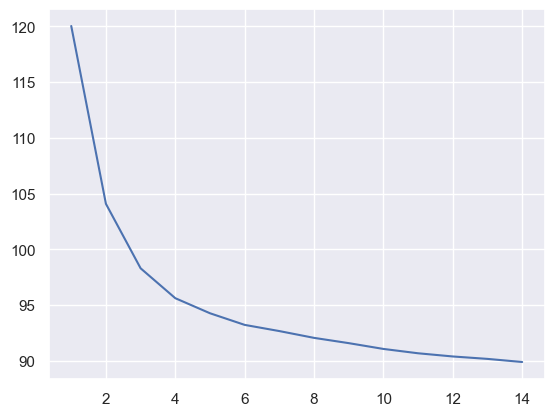

In [182]:
s0 = calculate_WSS(DF_fake_train[init_ret_features], 15)
plt.plot([k for k in range(1,15)], s0)

- The best value of k is found using the 'elbow method'.
- Here, however, it is a bit subjective. Let's try k = 6.

In [198]:
n_clusters = 6
kmeans = KMeans(n_clusters = n_clusters).fit(DF_fake_train[init_ret_features])

n_clusters += 1
DF_fake_train['Clusters'] = (1 + kmeans.predict(DF_fake_train[init_ret_features]))/(n_clusters*10)
DF_fake_test['Clusters'] = (1 + kmeans.predict(DF_fake_test[init_ret_features]))/(n_clusters*10)

In [200]:
features = DF_fake_train.columns
init_ret_features2 = np.append(init_ret_features1, np.array(['Clusters']))
corr = DF_fake_train.corr().loc[init_ret_features2, target_ret_features] # Compute Correlation between X and Y features 
nn = 10

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_fake_train['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_fake_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES


for alpha, l1_ratio in [(1e-5, 0.5)]:#(1e-5, 0), (1e-5, 0.1), (1e-5, 0.5)]:
    
    reg = ElasticNet(alpha=alpha, l1_ratio= l1_ratio)

    for id_target in tqdm(target_ret_features): # for every Y feature
        c = corr[id_target]
        ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
        j = int(id_target.replace('RET_', ''))

        reg.fit(DF_fake_train[ids_max], DF_fake_train[id_target])
        pred_train[id_target] = reg.predict(DF_fake_train[ids_max])
        pred_test[id_target] = reg.predict(DF_fake_test[ids_max])


    final_train = np.array([])
    final_test = np.array([])

    for idx in tqdm(X_fake_train['ID']):
        j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
        day = int(X_fake_train['ID_DAY'][idx])
        final_train = np.append(final_train, np.array([int(np.sign(pred_train[j].loc[day]))]))

    for idx in tqdm(X_fake_test['ID']):
        j = 'RET_'+str(int(X_fake_test['ID_TARGET'][idx]))
        day = int(X_fake_test['ID_DAY'][idx])
        final_test = np.append(final_test, np.array([int(np.sign(pred_test[j].loc[day]))]))

    print('alpha: ', alpha,', l1_ratio: ', l1_ratio,' -- ', 
        100*weighted_accuracy(Y_fake_train['RET_TARGET'].to_numpy(), final_train),'% vs ',
        100*weighted_accuracy(Y_fake_test['RET_TARGET'].to_numpy(), final_test),'%')
    

100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:03<00:00, 17834.70it/s]

alpha:  1e-05 , l1_ratio:  0.5  --  74.1976721840863 % vs  73.48609070071792 %


# Binary Classifiers

- The outcome that we want is, in fact, binary. So let us try to use some binary classifiers, to see how they perform.

In [201]:
DF_fake_train1 = DF_fake_train.copy()
DF_fake_test1 = DF_fake_test.copy()

DF_fake_train1[target_ret_features] = np.sign(DF_fake_train1[target_ret_features])
DF_fake_test1[target_ret_features] = np.sign(DF_fake_test1[target_ret_features])

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [214]:
features = DF_fake_train1.columns
corr = DF_fake_train1.corr().loc[init_ret_features2, target_ret_features] # Compute Correlation between X and Y features 
nn = 40

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_fake_train['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_fake_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES


for alpha, l1_ratio in [(1, 0.3), (10,0.8), (100,0.8)]:#(1e-5, 0), (1e-5, 0.1), (1e-5, 0.5)]:
    
    reg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', C = alpha, l1_ratio = l1_ratio)

    for id_target in tqdm(target_ret_features): # for every Y feature
        c = corr[id_target]
        ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
        j = int(id_target.replace('RET_', ''))

        reg.fit(DF_fake_train1[ids_max], DF_fake_train1[id_target])
        pred_train[id_target] = reg.predict(DF_fake_train1[ids_max])
        pred_test[id_target] = reg.predict(DF_fake_test1[ids_max])


    final_train = np.array([])
    final_test = np.array([])

    for idx in tqdm(X_fake_train['ID']):
        j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
        day = int(X_fake_train['ID_DAY'][idx])
        final_train = np.append(final_train, np.array([int(pred_train[j].loc[day])]))

    for idx in tqdm(X_fake_test['ID']):
        j = 'RET_'+str(int(X_fake_test['ID_TARGET'][idx]))
        day = int(X_fake_test['ID_DAY'][idx])
        final_test = np.append(final_test, np.array([int(pred_test[j].loc[day])]))

    print('alpha: ', alpha,', l1_ratio: ', l1_ratio,' -- ', 
        100*weighted_accuracy(Y_fake_train['RET_TARGET'].to_numpy(), final_train),'% vs ',
        100*weighted_accuracy(Y_fake_test['RET_TARGET'].to_numpy(), final_test),'%')
    

100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:02<00:00, 22196.14it/s]


alpha:  1 , l1_ratio:  0.3  --  72.56967684393483 % vs  71.39784050311077 %


100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:02<00:00, 22513.94it/s]


alpha:  10 , l1_ratio:  0.8  --  74.01313294687671 % vs  72.84036643662344 %


100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:02<00:00, 20640.29it/s]

alpha:  100 , l1_ratio:  0.8  --  74.0968860645923 % vs  72.84732985986345 %


- Grid search:     
    - nn=10 and (100,0.8): 73.19889388975291 % vs  72.84294313564664 %
    

### Random Forest Classifier

In [215]:
from sklearn.ensemble import RandomForestClassifier

In [224]:
features = DF_fake_train1.columns
corr = DF_fake_train1.corr().loc[init_ret_features2, target_ret_features] # Compute Correlation between X and Y features 
nn = 40

pred_train = pd.DataFrame()
pred_train['RET_139'] = DF_fake_train['RET_139']
pred_train['RET_139'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES

pred_test = pd.DataFrame()
pred_test['RET_216'] = DF_fake_test['RET_216']
pred_test['RET_216'] = 0 # MAKE SURE YOU HAVE THE RIGHT INDICES


for n_estimators, max_depth, ccp_alpha in [(450, 3, 0)]:#(1e-5, 0), (1e-5, 0.1), (1e-5, 0.5)]:
    
    reg = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, ccp_alpha = ccp_alpha) #ccp_alpha

    for id_target in tqdm(target_ret_features): # for every Y feature
        c = corr[id_target]
        ids_max = c.abs().sort_values(ascending=False)[:nn].index.to_numpy() # pick nn MAX correlations with some X feature    
        j = int(id_target.replace('RET_', ''))

        reg.fit(DF_fake_train1[ids_max], DF_fake_train1[id_target])
        pred_train[id_target] = reg.predict(DF_fake_train1[ids_max])
        pred_test[id_target] = reg.predict(DF_fake_test1[ids_max])


    final_train = np.array([])
    final_test = np.array([])

    for idx in tqdm(X_fake_train['ID']):
        j = 'RET_'+str(int(X_fake_train['ID_TARGET'][idx]))
        day = int(X_fake_train['ID_DAY'][idx])
        final_train = np.append(final_train, np.array([int(pred_train[j].loc[day])]))

    for idx in tqdm(X_fake_test['ID']):
        j = 'RET_'+str(int(X_fake_test['ID_TARGET'][idx]))
        day = int(X_fake_test['ID_DAY'][idx])
        final_test = np.append(final_test, np.array([int(pred_test[j].loc[day])]))

    print('n_est: ', n_estimators,', max_depth: ', max_depth,' -- ', 
        100*weighted_accuracy(Y_fake_train['RET_TARGET'].to_numpy(), final_train),'% vs ',
        100*weighted_accuracy(Y_fake_test['RET_TARGET'].to_numpy(), final_test),'%')
    

100%|█████████████████████████████████████████████████████████████████████████| 54192/54192 [00:02<00:00, 22525.96it/s]

n_est:  450 , max_depth:  3  --  75.16017763484876 % vs  72.82295198879748 %


- For nn = 20:
    - (250, 4): 76.5318428193584 % vs  72.91346860932181 %
    - (250, 3): 74.89641778199525 % vs  72.74284884830517

